In [2]:
# %% [markdown]
# ## Setup Environment
# Import dependencies, verify project structure, and set up device.

# %% [code]
import torch
import torch.optim as optim
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import import_ipynb

# Import modules
try:
    from src.preprocessing.data_collection import create_synthetic_dataset
    from src.preprocessing.normalize import normalize_dataset
    from src.preprocessing.dataset import get_dataloaders
    from src.models.hybrid_model import HybridModel
    from src.models.cnn_model import CNNModel
    from src.models.rnn_model import RNNModel
    from src.training.train_hybrid import train_hybrid
    from src.training.train_cnn import train_cnn
    from src.training.train_rnn import train_rnn
    from src.evaluation.evaluate import evaluate_hybrid, evaluate_cnn, evaluate_rnn, visualize_predictions
    print("All modules imported successfully")
except ImportError as e:
    print(f"Import error: {e}")
    print("Ensure all .ipynb and .py files exist and are valid in src/preprocessing/, src/training/, src/models/, and src/evaluation/")
    raise

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
os.makedirs("outputs/models", exist_ok=True)
os.makedirs("outputs/visualizations", exist_ok=True)

All modules imported successfully
Using device: cuda


In [ ]:
import os
from src.preprocessing.normalize import normalize_dataset

# Input directories
real_dir = "dataset/train/"
output_dir = "data/normalized/"

count = normalize_dataset(real_dir, output_dir)

In [ ]:
valid_dir = "dataset/valid/"
val_output_dir = "data/normalized/vaild"

count = normalize_dataset(valid_dir, val_output_dir)

In [ ]:
test_dir = "dataset/test/"
test_normalized_dir = "data/normalized/test"

count = normalize_dataset(test_dir, test_normalized_dir)

In [3]:
# %% [markdown]
# ## Create DataLoaders
# Load normalized images into PyTorch DataLoaders for training, validation, and testing.
from src.preprocessing.dataset import get_dataloaders

data = get_dataloaders(
    train_dir="data/normalized/train",
    val_dir="data/normalized/valid",
    test_dir="data/normalized/test",
    batch_size=32
)


Loading datasets using ImageFolder...
✓ Training samples: 87141
✓ Validation samples: 10896
✓ Test samples: 10896
✓ Classes: ['1', '10', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '19', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '2', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '21', '210', '211', '212', '

In [4]:
train_loader = data['train_loader']
val_loader = data['val_loader']
test_loader = data['test_loader']
classes = data['classes']
num_classes = data['num_classes']

print(f"Dataset size: {len(train_loader.dataset)}")
print(f"Dataset size: {len(val_loader.dataset)}")
print(f"Dataset size: {len(test_loader.dataset)}")
print(f"Number of characters: {len(classes)}")
print(f"Character to Index mapping: {num_classes}")




Dataset size: 87141
Dataset size: 10896
Dataset size: 10896
Number of characters: 454
Character to Index mapping: 454


In [6]:
import torch
import torch.optim as optim

# Get number of classes from dataloader
num_classes = data['num_classes']
print(f"Number of classes: {num_classes}")

# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

hybrid_model = HybridModel(num_classes).to(device)
cnn_model = CNNModel(num_classes).to(device)
rnn_model = RNNModel(num_classes=num_classes, hidden_size=256).to(device)

# Initialize optimizers with weight decay for regularization
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001, weight_decay=1e-5)
optimizer_rnn = optim.Adam(rnn_model.parameters(), lr=0.001, weight_decay=1e-5)

# Loss function for classification
criterion = torch.nn.CrossEntropyLoss()

print("✓ Models initialized successfully")
print(f"  Hybrid Model: {sum(p.numel() for p in hybrid_model.parameters()):,} parameters")
print(f"  CNN Model: {sum(p.numel() for p in cnn_model.parameters()):,} parameters")
print(f"  RNN Model: {sum(p.numel() for p in rnn_model.parameters()):,} parameters")

# Verify models are on correct device
print(f"\n✓ Models on {device}")
for name, model in [('Hybrid', hybrid_model), ('CNN', cnn_model), ('RNN', rnn_model)]:
    first_param = next(model.parameters())
    print(f"  {name}: {first_param.device}")

Number of classes: 454
Using device: cuda
✓ Models initialized successfully
  Hybrid Model: 8,532,550 parameters
  CNN Model: 5,904,326 parameters
  RNN Model: 989,126 parameters

✓ Models on cuda
  Hybrid: cuda:0
  CNN: cuda:0
  RNN: cuda:0


In [ ]:
# %% [markdown]
# ## Train Hybrid Model
# Train the CNN-RNN hybrid model with CTC loss.

# %% [code]
try:
    hybrid_model = train_hybrid(hybrid_model, train_loader, val_loader, device, optimizer_hybrid, epochs=10)
    torch.save(hybrid_model.state_dict(), "outputs/models/hybrid_model.pth")
    print("Hybrid model trained and saved")
except Exception as e:
    print(f"Error training hybrid model: {e}")

In [17]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

cnn_model, history = train_cnn(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_cnn,
    criterion=criterion,
    epochs=100
)
print("CNN model trained and saved")

Number of classes: 454
Epoch [1/100]
  Train Loss: 0.0026, Train Acc: 99.95%
  Val Loss: 0.8258, Val Acc: 94.39%
Epoch [5/100]
  Train Loss: 0.0029, Train Acc: 99.94%
  Val Loss: 0.9000, Val Acc: 94.60%
Epoch [10/100]
  Train Loss: 0.0025, Train Acc: 99.94%
  Val Loss: 1.0058, Val Acc: 94.75%
Epoch [15/100]
  Train Loss: 0.0018, Train Acc: 99.96%
  Val Loss: 0.8513, Val Acc: 95.12%
Epoch [20/100]
  Train Loss: 0.0017, Train Acc: 99.96%
  Val Loss: 0.8654, Val Acc: 94.48%
Epoch [25/100]
  Train Loss: 0.0019, Train Acc: 99.95%
  Val Loss: 0.7511, Val Acc: 94.47%
Epoch [30/100]
  Train Loss: 0.0021, Train Acc: 99.95%
  Val Loss: 0.8712, Val Acc: 94.73%
Epoch [35/100]
  Train Loss: 0.0020, Train Acc: 99.94%
  Val Loss: 1.0267, Val Acc: 94.26%
Epoch [40/100]
  Train Loss: 0.0021, Train Acc: 99.95%
  Val Loss: 1.1034, Val Acc: 94.29%
Epoch [45/100]
  Train Loss: 0.0020, Train Acc: 99.95%
  Val Loss: 1.0875, Val Acc: 94.48%
Epoch [50/100]
  Train Loss: 0.0015, Train Acc: 99.96%
  Val Loss: 0.

In [18]:
import json
with open('cnn_history_100.json', 'w') as f:
    json.dump(history, f)

In [20]:
torch.save(cnn_model.state_dict(), "outputs/models/cnn_model_100epoch.pth")
print("CNN model trained and saved")

CNN model trained and saved


In [1]:
import json
import matplotlib.pyplot as plt

def plot_training_history(history_file):
    """
    Load training history from JSON and display charts.
    
    Args:
        history_file: Path to saved JSON history file
    """
    # Load history from JSON
    with open(history_file, 'r') as f:
        history = json.load(f)
    
    # Create figure with subplots
    plt.figure(figsize=(14, 5))
    
    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
    plt.plot(history['val_loss'], label='Val Loss', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    plt.plot(history['val_acc'], label='Val Accuracy', linewidth=2)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n📊 Training Summary:")
    print(f"  Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"  Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"  Final Train Acc: {history['train_acc'][-1]:.2f}%")
    print(f"  Final Val Acc: {history['val_acc'][-1]:.2f}%")
    print(f"  Best Val Acc: {max(history['val_acc']):.2f}% (Epoch {history['val_acc'].index(max(history['val_acc'])) + 1})")


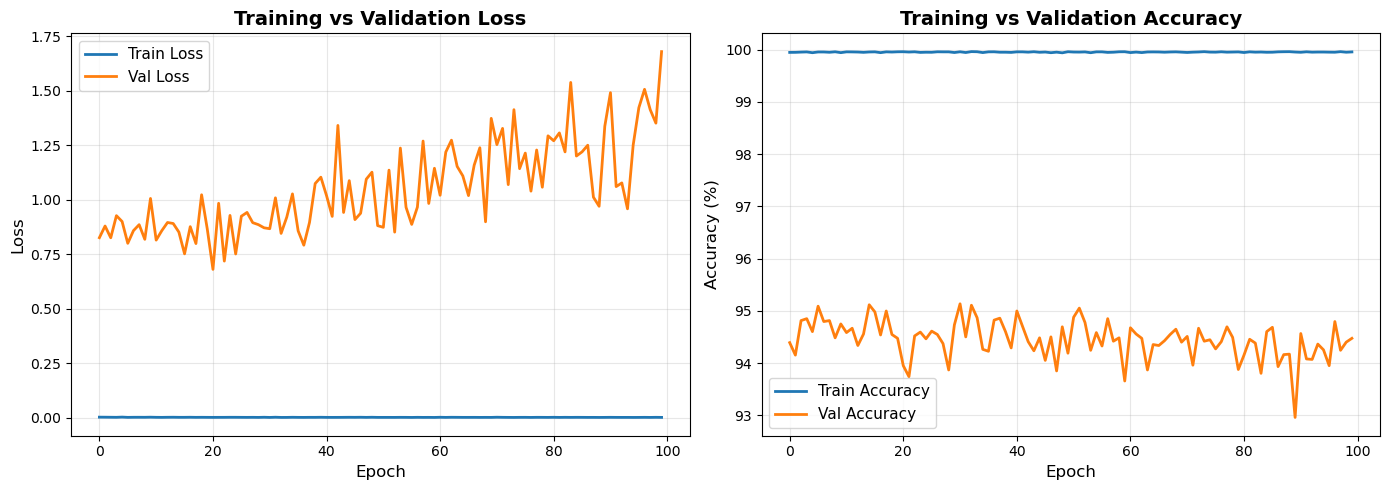


📊 Training Summary:
  Final Train Loss: 0.0015
  Final Val Loss: 1.6793
  Final Train Acc: 99.96%
  Final Val Acc: 94.48%
  Best Val Acc: 95.14% (Epoch 31)


In [8]:
plot_training_history('cnn_history_100.json')

In [7]:
# %% [markdown]
# ## Train RNN Model
# Train the standalone RNN model with CTC loss.

# %% [code]
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
rnn_model, history = train_rnn(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    optimizer=optimizer_rnn,
    criterion=criterion,
    epochs=50
)


Number of classes: 454
Epoch [1/50]
  Train Loss: 5.2478, Train Acc: 2.41%
  Val Loss: 4.2708, Val Acc: 7.52%


KeyboardInterrupt: 

In [ ]:
# %% [markdown]
# ## Evaluate Hybrid Model
# Compute CER, WER, and accuracy for the hybrid model.

# %% [code]
try:
    cer, wer, accuracy = evaluate_hybrid(hybrid_model, test_loader, char_to_idx, device)
    print(f"Hybrid Model - CER: {cer:.4f}, WER: {wer:.4f}, Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error evaluating Hybrid model: {e}")

In [ ]:
# %% [markdown]
# ## Evaluate CNN Model
# Compute accuracy for the CNN model.

# %% [code]
try:
    accuracy = evaluate_cnn(cnn_model, test_loader, char_to_idx, device)
    print(f"CNN Model - Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error evaluating CNN model: {e}")

In [ ]:
# %% [markdown]
# ## Evaluate RNN Model
# Compute CER, WER, and accuracy for the RNN model.

# %% [code]
try:
    cer, wer, accuracy = evaluate_rnn(rnn_model, test_loader, char_to_idx, device)
    print(f"RNN Model - CER: {cer:.4f}, WER: {wer:.4f}, Accuracy: {accuracy:.4f}")
except Exception as e:
    print(f"Error evaluating RNN model: {e}")

In [ ]:
# %% [markdown]
# ## Visualize Predictions
# Generate and display sample predictions for hybrid and RNN models.

# %% [code]
visualize_predictions(hybrid_model, test_loader, char_to_idx, device, num_samples=5)
visualize_predictions(rnn_model, test_loader, char_to_idx, device, num_samples=5)
print("Visualizations saved in outputs/visualizations/")